# Baysian Optimisation to find good Hyperparameters
To  find a good set of hyperparameters for the XGB model, a Baysian optimisation based on a time based train test split is used. This is done because the model will try to run inference based on predicted weather data. So a time based train test split where the entire data set minus one week is the train set and the test set is the final week. This ensures that we optimize the model for the correct purpose.

In [3]:
# Library Imports
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

# Data import
df = pd.read_csv("../data/finalData2.csv")
df['time'] = pd.to_datetime(df['time'])
df.drop(["Unnamed: 0",'oerlikon'],axis = 1  ,inplace=True)
stop = df['time'].iloc[-1]
start = stop - pd.Timedelta(weeks=1)
timemask = (df['time'] >= start) & (df['time'] <= stop)
time = df['time']
df.drop('time', axis = 1, inplace = True)
X_train = df[timemask == 0].drop('city', axis = 1)
y_train = df[timemask == 0]['city']
X_test = df[timemask].drop('city', axis = 1)
y_test = df[timemask]['city']

## Baseline
For compairison later on we use a xgb model with default para meters

Text(0.5, 1.0, 'MSE 385.81975861542185')

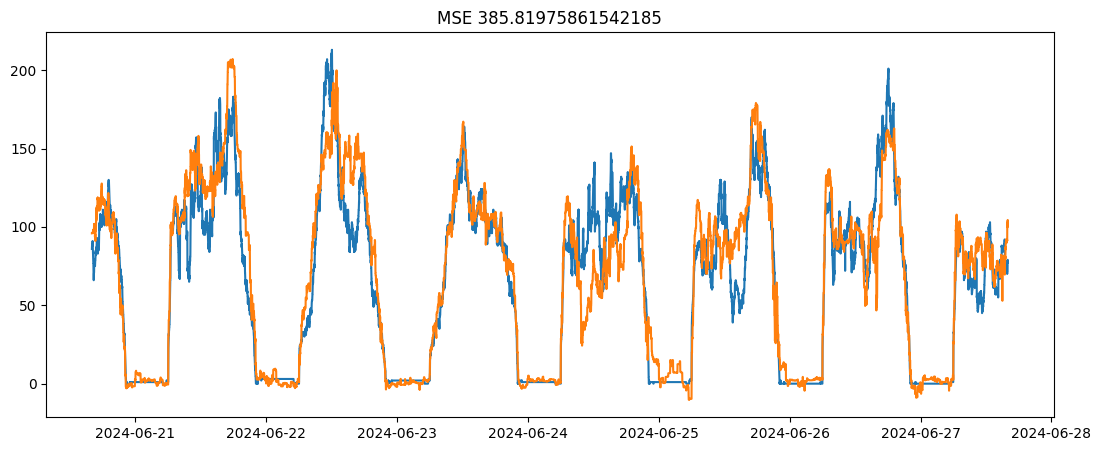

In [4]:
# Train
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

# Inference
y_pred = reg.predict(X_test)

# Plot
plt.figure(figsize=(13,5))
plt.plot(time[timemask], y_test, marker = " ")
plt.plot(time[timemask], y_pred, marker = " ")
plt.title(f"MSE {mse(y_pred, y_test)}")



# Optimizing
Code is based on [this](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)

In [ ]:
import optuna

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "n_estimators": trial.suggest_int("n_estimators",5,500),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # bst = xgb.train(param, X_train)
    reg = xgb.XGBRegressor(**param)
    reg.fit(X_train, y_train)
    y_pred =  reg.predict(X_test)
    return mse(y_pred, y_test)



study = optuna.create_study(direction="minimize", storage='sqlite:///optuna.db', study_name='XGB-RUN-2-n_estimators')
study.optimize(objective, n_trials=100, n_jobs = 20)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-10 10:57:27,554] A new study created in RDB with name: XGB-RUN-2-n_estimators
[I 2024-10-10 10:57:31,127] Trial 17 finished with value: 887.2053075711199 and parameters: {'booster': 'gblinear', 'lambda': 1.6119539021016694e-08, 'alpha': 0.007515527757767123, 'subsample': 0.35668140433659873, 'colsample_bytree': 0.519789691792133, 'n_estimators': 27}. Best is trial 17 with value: 887.2053075711199.
[I 2024-10-10 10:57:36,762] Trial 19 finished with value: 808.6401356790359 and parameters: {'booster': 'gblinear', 'lambda': 0.04155406288934962, 'alpha': 0.35687317170944916, 'subsample': 0.7225221388744831, 'colsample_bytree': 0.5424546914924041, 'n_estimators': 103}. Best is trial 19 with value: 808.6401356790359.
[I 2024-10-10 10:57:37,108] Trial 9 finished with value: 1335.9388429335893 and parameters: {'booster': 'gblinear', 'lambda': 2.0892779041116955e-07, 'alpha': 7.824140637648448e-05, 'subsample': 0.5466288397338435, 'colsample_bytree': 0.6215680831206454, 'n_estimators

# Eval of the optimisation

In [10]:
study.best_params


{'booster': 'gbtree',
 'lambda': 0.11539465739958492,
 'alpha': 2.3196358005396178e-07,
 'subsample': 0.7191936744778141,
 'colsample_bytree': 0.8429927449514272,
 'max_depth': 7,
 'min_child_weight': 10,
 'eta': 0.05805795952478799,
 'gamma': 0.0002612449213635085,
 'grow_policy': 'lossguide'}

study